In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from torch.utils.data import DataLoader, TensorDataset

In [12]:
# Function to generate Gaussian Mixture Model (GMM) dataset
def generate_gaussian_mixture(n_samples=500, grid_size=5, std_dev=0.05):
    centers = np.array([(x-2, y-2) for x in range(grid_size) for y in range(grid_size)])
    data = []
    labels = []
    for i, center in enumerate(centers):
        samples = np.random.normal(loc=center, scale=std_dev, size=(n_samples, 2))
        data.append(samples)
        labels.extend([i] * n_samples)
    return np.vstack(data), np.array(labels), centers  # Return centers too


In [13]:
# Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim=2):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [16]:
def train_BasicGAN(generator, discriminator, data, labels_x, lr=0.0005, 
                   criterion=nn.BCELoss(), latent_dim=100, n_epochs=200, window_size=50):
    
    tensor_data = torch.tensor(data, dtype=torch.float32)
    tensor_labels = torch.tensor(labels_x, dtype=torch.long)
    dataset = TensorDataset(tensor_data, tensor_labels)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    d_losses, g_losses = [], []
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Store full LDR history per class (instead of deque)
    ldr_history = {class_id: [] for class_id in range(25)}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    for epoch in range(n_epochs):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            batch_size = imgs.size(0)
            
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z)
            
            # Train Discriminator
            d_optimizer.zero_grad()
            real_output = discriminator(imgs)
            fake_output = discriminator(fake_imgs.detach())
            real_loss = criterion(real_output, real_labels)
            fake_loss = criterion(fake_output, fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            g_loss = criterion(discriminator(fake_imgs), real_labels)
            g_loss.backward()
            g_optimizer.step()
        
        # Compute LDR values for a randomly selected subset
        with torch.no_grad():
            indices = torch.randperm(len(data))[:10000]  # Randomly select 10,000 indices
            sampled_data = tensor_data[indices].to(device)  # Select data
            sampled_labels = tensor_labels[indices].to(device)  # Select labels

            D_x_real_batch = discriminator(sampled_data).squeeze()

            for mode_id in range(25):
                mode_indices = (sampled_labels == mode_id).nonzero(as_tuple=True)[0]  # Get indices
                
                if len(mode_indices) > 0:  # Ensure there are valid samples
                    D_x_real = D_x_real_batch[mode_indices]  # Select valid samples
                    eps = 1e-6
                    LDR_x_real = torch.log(D_x_real / (1 - D_x_real + eps))
                    ldr_history[mode_id].append(LDR_x_real.mean().item())  # Store mean for stability

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # Debugging: Print sample LDR values every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: D Loss = {d_loss.item():.4f}, G Loss = {g_loss.item():.4f}")
            print("Sample LDR values:")
            for mode_id in range(5):  # Print only for first 5 classes
                if len(ldr_history[mode_id]) > 0:
                    print(f"  Class {mode_id}: {ldr_history[mode_id][-1]:.4f}")

        # Generate samples & visualize every 50 epochs
        if epoch % 50 == 0:
            with torch.no_grad():
                z = torch.randn(10000, latent_dim, device=device)
                fake_imgs = generator(z).cpu().numpy()  # Move to CPU for plotting
                plt.figure(figsize=(3, 3))
                plt.scatter(fake_imgs[:, 0], fake_imgs[:, 1], alpha=0.5, s=2)
                plt.xlim(-3, 3)  # Set x-axis limits
                plt.ylim(-3, 3)  # Set y-axis limits
                plt.xlabel('X')
                plt.ylabel('Y')
                plt.title(f'Generated Samples at Epoch {epoch}')
                plt.show()

    # Compute LDRM heatmap (moving average over `window_size` epochs)
    num_epochs_valid = len(d_losses)  # Use full epoch range
    ldrm_values = np.zeros((25, num_epochs_valid))  # Shape: (25 modes, num_epochs_valid)

    for mode_id in range(25):
        mode_ldr = np.array(ldr_history[mode_id])  # Convert list to NumPy array

        if len(mode_ldr) > 0:  # Ensure we have LDR values
            for i in range(len(mode_ldr)):  # Use full length
                start_idx = max(0, i - window_size + 1)  # Rolling window start
                end_idx = i + 1  # Current epoch included
                
                # Compute moving average only on available values
                ldrm_values[mode_id, i] = np.mean(mode_ldr[start_idx:end_idx])

    # Plot LDRM heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(ldrm_values, cmap='coolwarm', linewidths=0.5, linecolor='gray')

    # Set x-axis ticks dynamically
    num_epochs = ldrm_values.shape[1]
    tick_positions = np.linspace(0, num_epochs - 1, num=10, dtype=int)  # Adjust tick density
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_positions)

    plt.xlabel('Epoch')
    plt.ylabel('Class ID')
    plt.title('Moving Average LDRM Heatmap (T=50)')
    plt.show()
    
    return ldrm_values, d_losses, g_losses



Epoch 0: D Loss = 1.3765, G Loss = 0.7000
Sample LDR values:
  Class 0: 0.2731
  Class 1: 0.1141
  Class 2: -0.0047
  Class 3: 0.0858
  Class 4: 0.2089


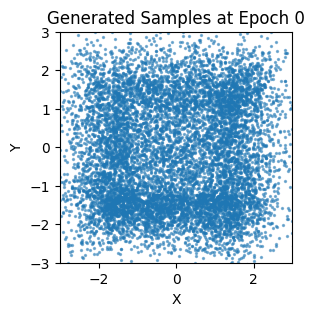

Epoch 50: D Loss = 0.9960, G Loss = 1.1930
Sample LDR values:
  Class 0: -0.6384
  Class 1: 2.8169
  Class 2: 2.7696
  Class 3: -0.3768
  Class 4: -0.3543


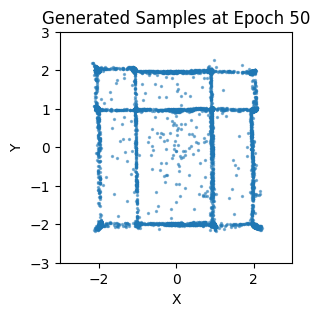

Epoch 100: D Loss = 1.1638, G Loss = 1.4879
Sample LDR values:
  Class 0: -2.2576
  Class 1: 2.9591
  Class 2: 2.8819
  Class 3: -0.6692
  Class 4: -0.6221


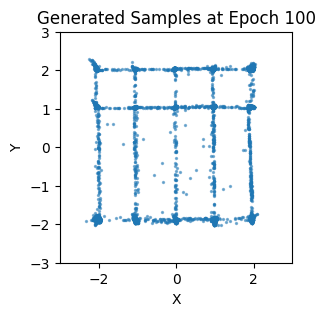

Epoch 150: D Loss = 1.0508, G Loss = 1.0087
Sample LDR values:
  Class 0: -0.3627
  Class 1: 3.7012
  Class 2: 3.6435
  Class 3: -0.2772
  Class 4: -0.6114


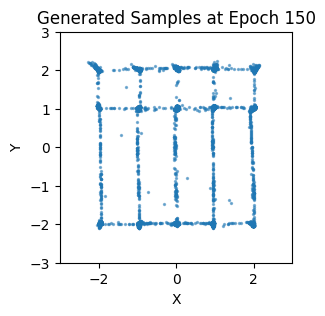

Epoch 200: D Loss = 1.3308, G Loss = 0.8934
Sample LDR values:
  Class 0: -0.1361
  Class 1: 0.3604
  Class 2: 3.9694
  Class 3: 0.3516
  Class 4: 0.8726


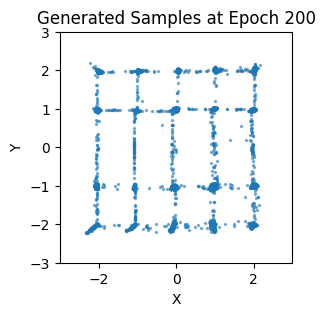

Epoch 250: D Loss = 1.2757, G Loss = 0.8809
Sample LDR values:
  Class 0: -0.5610
  Class 1: -0.0448
  Class 2: 3.4204
  Class 3: 0.0106
  Class 4: 0.2850


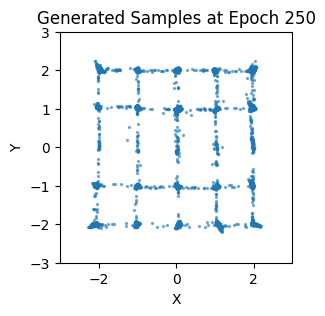

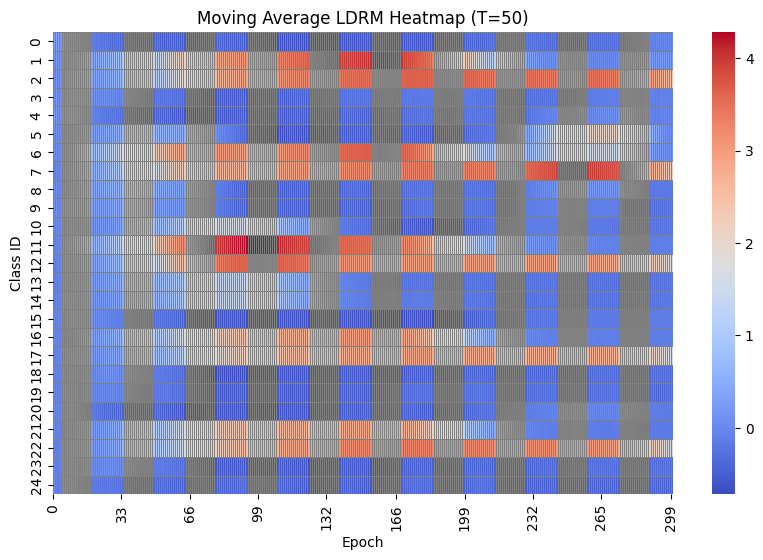

In [17]:



# Generate 25 Gaussian Dataset
data, labels, centers = generate_gaussian_mixture(n_samples=1000)


# Initialize Generator and Discriminator
generator = Generator(latent_dim=2)
discriminator = Discriminator(input_dim=2)

# Train GAN
ldrm_values, d_losses, g_losses = train_BasicGAN(generator, discriminator, data, labels, latent_dim=2, n_epochs=300)



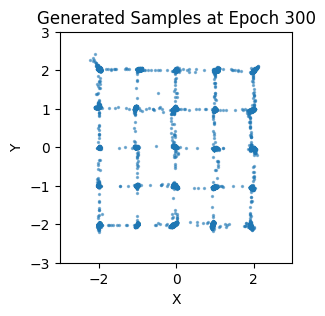

In [24]:
with torch.no_grad():
    z = torch.randn(10000, 2)
    fake_imgs = generator(z).cpu().numpy()  # Move to CPU for plotting
    plt.figure(figsize=(3, 3))
    plt.scatter(fake_imgs[:, 0], fake_imgs[:, 1], alpha=0.5, s=2)
    plt.xlim(-3, 3)  # Set x-axis limits
    plt.ylim(-3, 3)  # Set y-axis limits
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Generated Samples at Epoch {300}')
    plt.show()
